In [114]:
import numpy as np 
import pandas as pd 
import options_trading as opt 
import pricing 
from fredapi import Fred
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import model_calibration as model
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Calculate the price of a bond

In [ ]:
### Bootstrap method to get the zero rate curve approximation and then use it to give the price

#FRED API : 54dc21b344d021c79ae6bcd13013fd62

### Get market prices

# TLT : ETF suit obligations américaines à long terme (+30 ans)
# SHY : ETF suit obligations américaines à court terme (1-3 ans)
# ^IRX : T-bills
# API FRED (Federal Reserve Economic Data) : DGS10 pour taux treasuries à 10 ans

In [14]:
fred = Fred(api_key='54dc21b344d021c79ae6bcd13013fd62')

In [113]:
data = fred.get_series('DGS10', observation_start='2010-01-01', observation_end=datetime.today())
data

2010-01-01     NaN
2010-01-04    3.85
2010-01-05    3.77
2010-01-06    3.85
2010-01-07    3.85
              ... 
2024-11-15    4.43
2024-11-18    4.42
2024-11-19    4.39
2024-11-20    4.41
2024-11-21    4.43
Length: 3885, dtype: float64

In [40]:
us10 = yf.download('^IRX', start='2010-01-01')
us10

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,0.080,0.080,0.055,0.055,0.055,0
2010-01-05,0.060,0.065,0.040,0.060,0.060,0
2010-01-06,0.060,0.060,0.045,0.045,0.045,0
2010-01-07,0.045,0.055,0.040,0.045,0.045,0
2010-01-08,0.045,0.045,0.035,0.040,0.040,0
...,...,...,...,...,...,...
2024-11-15,4.390,4.397,4.385,4.393,4.393,0
2024-11-18,4.395,4.403,4.393,4.403,4.403,0
2024-11-19,4.408,4.410,4.403,4.408,4.408,0


In [ ]:
# Bootstrap method : 
# 3 months, 6 months, 1 year, 2, years, 3 years, 5, 7, 10 years

In [41]:
data_3m = fred.get_series('DGS3MO', observation_start='2010-01-01', observation_end='2024-11-20')
data_6m = fred.get_series('DGS6MO', observation_start='2010-01-01', observation_end='2024-11-20')
data_1y = fred.get_series('DGS1', observation_start='2010-01-01', observation_end='2024-11-20')
data_2y = fred.get_series('DGS2', observation_start='2010-01-01', observation_end='2024-11-20')
data_3y = fred.get_series('DGS3', observation_start='2010-01-01', observation_end='2024-11-20')
data_5y = fred.get_series('DGS5', observation_start='2010-01-01', observation_end='2024-11-20')
data_7y = fred.get_series('DGS7', observation_start='2010-01-01', observation_end='2024-11-20')
data_10y = fred.get_series('DGS10', observation_start='2010-01-01', observation_end='2024-11-20')

In [93]:
dataset = pd.concat([data_3m, data_6m, data_1y, data_2y, data_3y, data_5y, data_7y, data_10y], axis=1)
dataset.columns = ['3m', '6m', '1y', '2y', '3y', '5y', '7y', '10y']
dataset.dropna(inplace=True)
#dataset[["9m", "4y", "6y", "8y", "9y"]]=np.nan
#dataset=dataset[["3m", "6m", "9m", "1y", "2y", "3y", "4y", "5y", "6y", "7y", "8y", "9y", "10y"]]
# for i in range(dataset.shape[0]):
#   dataset.iloc[i, :] = dataset.iloc[i, :].interpolate(method='linear')
#dataset = dataset.interpolate(method='linear', axis=1)
dataset

,3m,6m,1y,2y,3y,5y,7y,10y
2010-01-04,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85
2010-01-05,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77
2010-01-06,0.06,0.15,0.40,1.01,1.60,2.60,3.33,3.85
2010-01-07,0.05,0.16,0.40,1.03,1.62,2.62,3.33,3.85
2010-01-08,0.05,0.15,0.37,0.96,1.56,2.57,3.31,3.83
...,...,...,...,...,...,...,...,...
2024-11-14,4.61,4.43,4.36,4.34,4.30,4.32,4.38,4.43
2024-11-15,4.60,4.44,4.34,4.31,4.27,4.30,4.36,4.43
2024-11-18,4.63,4.44,4.33,4.29,4.25,4.28,4.35,4.42
2024-11-19,4.62,4.44,4.34,4.27,4.24,4.25,4.32,4.39


In [123]:
dataset = pd.concat([data_3m, data_6m, data_1y, data_2y, data_3y, data_5y, data_7y, data_10y], axis=1)
dataset.columns = ['3', '6', '12', '24', '36', '60', '84', '120']
dataset.dropna(inplace=True)

#all_months = range(1, 121)
#for month in all_months:
#    if str(month) not in dataset.columns :
#        dataset[f'{month}']=np.nan
#right_index=[f'{i}' for i in all_months]
#dataset = dataset[right_index]

In [107]:
dataset = dataset.interpolate(method='linear', axis=1)
dataset

,1,2,3,4,5,6,7,8,9,10,...,111,112,113,114,115,116,117,118,119,120
2010-01-04,NaN,NaN,0.08,0.113333,0.146667,0.18,0.225000,0.270000,0.315,0.360000,...,3.7275,3.741111,3.754722,3.768333,3.781944,3.795556,3.809167,3.822778,3.836389,3.85
2010-01-05,NaN,NaN,0.07,0.103333,0.136667,0.17,0.210000,0.250000,0.290,0.330000,...,3.6475,3.661111,3.674722,3.688333,3.701944,3.715556,3.729167,3.742778,3.756389,3.77
2010-01-06,NaN,NaN,0.06,0.090000,0.120000,0.15,0.191667,0.233333,0.275,0.316667,...,3.7200,3.734444,3.748889,3.763333,3.777778,3.792222,3.806667,3.821111,3.835556,3.85
2010-01-07,NaN,NaN,0.05,0.086667,0.123333,0.16,0.200000,0.240000,0.280,0.320000,...,3.7200,3.734444,3.748889,3.763333,3.777778,3.792222,3.806667,3.821111,3.835556,3.85
2010-01-08,NaN,NaN,0.05,0.083333,0.116667,0.15,0.186667,0.223333,0.260,0.296667,...,3.7000,3.714444,3.728889,3.743333,3.757778,3.772222,3.786667,3.801111,3.815556,3.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-14,NaN,NaN,4.61,4.550000,4.490000,4.43,4.418333,4.406667,4.395,4.383333,...,4.4175,4.418889,4.420278,4.421667,4.423056,4.424444,4.425833,4.427222,4.428611,4.43
2024-11-15,NaN,NaN,4.60,4.546667,4.493333,4.44,4.423333,4.406667,4.390,4.373333,...,4.4125,4.414444,4.416389,4.418333,4.420278,4.422222,4.424167,4.426111,4.428056,4.43
2024-11-18,NaN,NaN,4.63,4.566667,4.503333,4.44,4.421667,4.403333,4.385,4.366667,...,4.4025,4.404444,4.406389,4.408333,4.410278,4.412222,4.414167,4.416111,4.418056,4.42
2024-11-19,NaN,NaN,4.62,4.560000,4.500000,4.44,4.423333,4.406667,4.390,4.373333,...,4.3725,4.374444,4.376389,4.378333,4.380278,4.382222,4.384167,4.386111,4.388056,4.39


In [124]:
all_months = [str(month) for month in range(1, 121)]

missing_columns = [month for month in all_months if month not in dataset.columns]
missing_df = pd.DataFrame(np.nan, index=dataset.index, columns=missing_columns)

dataset = pd.concat([dataset, missing_df], axis=1)

right_index=[f'{i}' for i in all_months]
dataset = dataset[right_index]

In [125]:
dataset

,1,2,3,4,5,6,7,8,9,10,...,111,112,113,114,115,116,117,118,119,120
2010-01-04,NaN,NaN,0.08,NaN,NaN,0.18,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.85
2010-01-05,NaN,NaN,0.07,NaN,NaN,0.17,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.77
2010-01-06,NaN,NaN,0.06,NaN,NaN,0.15,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.85
2010-01-07,NaN,NaN,0.05,NaN,NaN,0.16,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.85
2010-01-08,NaN,NaN,0.05,NaN,NaN,0.15,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-14,NaN,NaN,4.61,NaN,NaN,4.43,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.43
2024-11-15,NaN,NaN,4.60,NaN,NaN,4.44,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.43
2024-11-18,NaN,NaN,4.63,NaN,NaN,4.44,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.42
2024-11-19,NaN,NaN,4.62,NaN,NaN,4.44,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.39


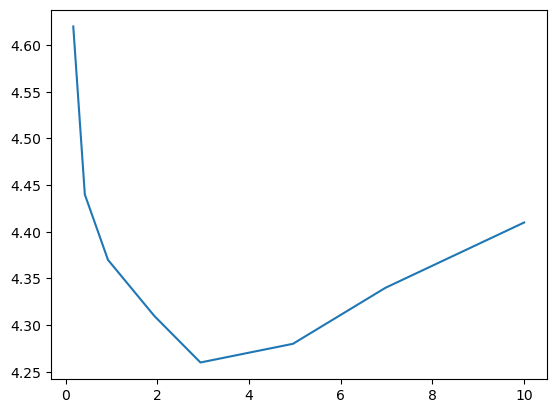

In [109]:
plt.plot(np.linspace(0, 10, 120), dataset.iloc[-1, :])

In [ ]:
def bond_pricing(r, T, A, coupon_percentage, nb_coupons):
    """ 
    A : principal
    r : interest rate
    T : maturity
    coupon_percentage : coupon value in percentage of the principal --> by year !!
    nb_coupons : number of coupons during the bond life
    """
    coupon=coupon_percentage*A
    payments=np.linspace(0, T, nb_coupons)
    price=[coupon*np.exp(-r*payment) for payment in payments]

    price.append(A*np.exp(-r*T))

    return sum(price)

In [8]:
bond_pricing(0.03, 2, 100, 0.03, 4)

105.82471129655485